## Homework 4

Use this notebook as a starter

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc


%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
if not os.path.exists("CreditScoring.csv"):
    !wget $data


## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [4]:
df.status

0       1
1       1
2       2
3       1
4       1
       ..
4450    2
4451    1
4452    2
4453    1
4454    1
Name: status, Length: 4455, dtype: int64

Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [6]:
df.status

0            ok
1            ok
2       default
3            ok
4            ok
         ...   
4450    default
4451         ok
4452    default
4453         ok
4454         ok
Name: status, Length: 4455, dtype: object

Prepare the numerical variables:

In [7]:
df['income'].describe()

count    4.455000e+03
mean     7.633170e+05
std      8.703625e+06
min      0.000000e+00
25%      8.000000e+01
50%      1.200000e+02
75%      1.660000e+02
max      1.000000e+08
Name: income, dtype: float64

In [8]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [9]:
df['income'].describe()

count    4455.000000
mean      129.571717
std        86.784427
min         0.000000
25%        80.000000
50%       119.000000
75%       164.000000
max       959.000000
Name: income, dtype: float64

Remove clients with unknown default status

In [10]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [11]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [12]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical.append('default')
df[categorical]

,home,marital,records,job,default
0,rent,married,no,freelance,0
1,rent,widow,no,fixed,0
2,owner,married,yes,freelance,1
3,rent,single,no,fixed,0
4,rent,single,no,fixed,0
...,...,...,...,...,...
4449,rent,married,no,fixed,1
4450,owner,married,no,fixed,0
4451,owner,married,no,partime,1
4452,rent,single,no,freelance,0


In [13]:
numerical = list(df.dtypes[df.dtypes == 'int64'].index)
numerical.remove('default')
df[numerical]

,seniority,time,age,expenses,income,assets,debt,amount,price
0,9,60,30,73,129,0,0,800,846
1,17,60,58,48,131,0,0,1000,1658
2,10,36,46,90,200,3000,0,2000,2985
3,0,60,24,63,182,2500,0,900,1325
4,0,36,26,46,107,0,0,310,910
...,...,...,...,...,...,...,...,...,...
4449,1,60,39,69,92,0,0,900,1020
4450,22,60,46,60,75,3000,600,950,1263
4451,0,24,37,60,90,3500,0,500,963
4452,0,48,23,49,140,0,0,550,550


In [14]:
print(f"[ANSWER -1] Numerical variables are:  {numerical}\nCategorical variables are: {categorical}")

[ANSWER -1] Numerical variables are:  ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']
Categorical variables are: ['home', 'marital', 'records', 'job', 'default']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

,feat,auc
0,seniority,0.709378
1,income,0.682007
2,assets,0.648604
3,amount,0.591077
4,age,0.573293
5,time,0.560866
6,debt,0.504783
7,price,0.504333
8,expenses,0.500918


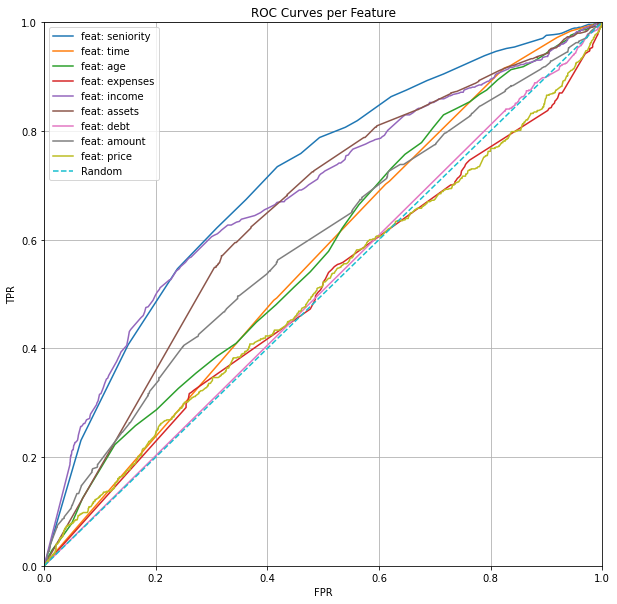

In [16]:
result_list = list()
column_list = ["feat", "auc"]
plot_size = 10
plt.figure(figsize=(plot_size, plot_size))

for c in numerical:
    fpr, tpr, thresholds = roc_curve(df_train.default, df_train[c])
    auc_score = auc(fpr, tpr)
    if auc_score < 0.5:
        fpr, tpr, thresholds = roc_curve(df_train.default, -df_train[c])
        auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'feat: {c}')
    result_list.append([c, auc_score])


df_auc_scores = pd.DataFrame(result_list, columns=column_list)

plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("ROC Curves per Feature")
plt.grid(True)
plt.legend()

df_auc_scores.sort_values(by="auc", ascending=False).reset_index(drop=True)

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [17]:
print("[ANSWER-1] The numerical variable with highest AUC is seniority with 0.709378")

[ANSWER-1] The numerical variable with highest AUC is seniority with 0.709378


## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [18]:
# I use the function defined in the session for this
def train(df_train, y_train, feat_list, C=1.0, max_iter=1000):
    dicts = df_train[feat_list].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=max_iter)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model, feat_list):
    dicts = df[feat_list].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [19]:
feat_list = ['seniority', 'income', 'assets', 'records', 'job', 'home']
dv, model = train(df_train, df_train.default, feat_list=feat_list)

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [20]:
y_pred = predict(df_val, dv, model, feat_list=feat_list)
y_pred

array([1.96864517e-01, 1.17566830e-01, 2.69816999e-01, 1.23272297e-01,
       4.14163558e-02, 6.03395041e-01, 8.47303706e-01, 2.30826676e-01,
       9.20153615e-01, 3.40257142e-01, 3.19613906e-01, 6.28633454e-02,
       4.05811355e-01, 4.06879435e-01, 1.01941492e-01, 7.06995810e-02,
       3.02017778e-02, 2.74911652e-01, 7.92665974e-01, 5.23975117e-02,
       4.90721608e-01, 1.33304655e-01, 7.04819954e-02, 1.78498677e-02,
       4.18153981e-01, 5.33852022e-01, 5.31608722e-01, 1.02859300e-01,
       4.30786409e-01, 2.42859212e-02, 2.25436210e-01, 4.93559876e-02,
       3.15443702e-01, 1.23846910e-01, 6.97466123e-01, 8.41046084e-02,
       5.28890028e-02, 6.76631141e-01, 1.11294087e-01, 1.21434239e-01,
       3.95982795e-01, 1.00225341e-01, 1.12215164e-01, 1.76622050e-01,
       1.22913696e-01, 5.37205476e-01, 7.96489211e-01, 6.94633964e-01,
       6.10214554e-02, 2.27408800e-02, 3.36416888e-01, 1.06107907e-01,
       8.43867781e-02, 5.33933185e-01, 1.53052162e-01, 5.56195627e-01,
      

In [21]:
roc_auc_score(df_val.default, y_pred)
print(f"[ANSWER-2] The AUC of the model is: {round(roc_auc_score(df_val.default, y_pred), 3)}")

[ANSWER-2] The AUC of the model is: 0.812


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [22]:
pr_results = list()
thresholds = np.linspace(0,1,100)
for thr in thresholds:
    actual_positive = (df_val.default == 1)
    actual_negative = (df_val.default == 0)
    
    predict_positive = (y_pred >= thr)
    predict_negative = (y_pred < thr)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    #print([thr, tp, tn, fp, fn])
    
    pr_results.append([thr, tp, tn, fp, fn])

df_pr = pd.DataFrame(pr_results, columns=["thr", "tp", "tn", "fp", "fn"])
df_pr.head()

,thr,tp,tn,fp,fn
0,0.000000,246,0,645,0
1,0.010101,246,10,635,0
2,0.020202,244,32,613,2
3,0.030303,242,53,592,4
4,0.040404,242,82,563,4


In [23]:
df_pr["precision"] = df_pr.tp / (df_pr.tp + df_pr.fp)
df_pr["recall"] = df_pr.tp / (df_pr.tp + df_pr.fn)

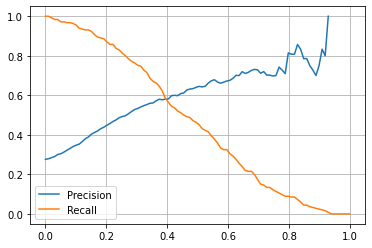

In [24]:
plt.plot(df_pr.thr, df_pr['precision'], label='Precision')
plt.plot(df_pr.thr, df_pr['recall'], label='Recall')
plt.grid(True)
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

In [25]:
print(f"[ANSWER-3] Precision and Recall curves intersect at thr == 0.4 (aproximately)")

[ANSWER-3] Precision and Recall curves intersect at thr == 0.4 (aproximately)


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [26]:
df_pr["f1_score"] = 2 * (df_pr["precision"] * df_pr["recall"])/(df_pr["precision"] + df_pr["recall"])

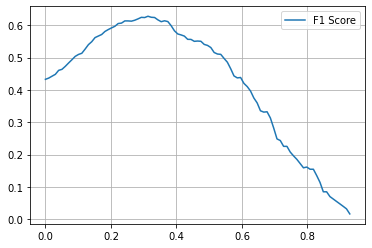

In [27]:
plt.plot(df_pr.thr, df_pr['f1_score'], label='F1 Score')
plt.grid(True)
plt.legend()

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [28]:
print(f"[ANSWER-4] F1 Score has max value at thr == 0.3 (aproximately)")

[ANSWER-4] F1 Score has max value at thr == 0.3 (aproximately)


## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [29]:
df_full_train[feat_list].columns

Index(['seniority', 'income', 'assets', 'records', 'job', 'home'], dtype='object')

In [30]:
feat_list

['seniority', 'income', 'assets', 'records', 'job', 'home']

In [31]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train): 
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    dv, model = train(df_train, df_train.default, feat_list=feat_list)
    y_pred = predict(df_val, dv, model, feat_list=feat_list)

    auc = roc_auc_score(df_val.default, y_pred)
    scores.append(auc)

print(' %.3f +- %.4f' % (np.mean(scores), np.std(scores)))
    

 0.814 +- 0.0146


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

In [32]:
print(f"[ANSWER-5] The standard deviation is: 0.014")

[ANSWER-5] The standard deviation is: 0.014


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [33]:
for C in (0.01, 0.1, 1, 10):
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train): 
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        dv, model = train(df_train, df_train.default, feat_list=feat_list, C=C)
        y_pred = predict(df_val, dv, model, feat_list=feat_list)

        auc = roc_auc_score(df_val.default, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=10 0.812 +- 0.014


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [34]:
print(f"[ANSWER-6] C=1 leads the best mean score (0.814)")

[ANSWER-6] C=1 leads the best mean score (0.814)


## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.